# バギングとペースティング

全て**同じ分類器で，同じ訓練データ**を使いつつ，訓練セットから無作為に別々のサブセットをサンプリングして訓練するアプローチ．

サンプリングが**重複あり**で行われるものを**バギング**(bagging, bootstrap aggregatingの略(重複ありのリサンプリングをブートストラップ法と言う))，**重複なし**で行われるものを**ペースティング**と呼ぶ

集計関数は一般的に分類はモード（最頻値），回帰は平均である．  
個々の分類器はサブセットで訓練するのでバイアスが高くなるが，集計によってバイアスは下がるし，全てのデータを一度に訓練するよりもバリアンスは下がる．  
全ての分類器を，異なるCPUコアや異なるサーバーを使って並列実行できることも，バギングやペースティングが人気の理由である．

In [ ]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

バギングかペースティングかは**bootstrap**パラメータで変更可能．  
予測器の数は**n_estimators**,  
CPUコア数は**n_jobs**（-1の場合，使える全てのコアを使う）

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [6]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [7]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


１本の決定木よりもバギングの方が性能が高い！！

In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

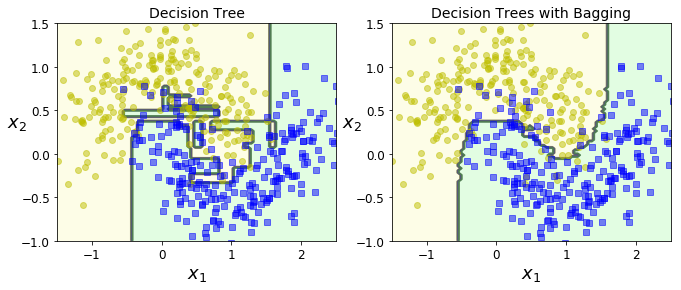

In [10]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

バギングの方がバリアンスが低く（過学習してない），汎化性能が高い．

ブートストラップ法の方が，個々の予測器が訓練に使うサブセットの**多様性が若干上がる**ため，個々の分類器のバイアスは上がり，つまり個々の分類器どうしの相関が低くなるため，アンサンブルした時にバリアンスが低下し結果的に性能が高くなる．  
このためペースティングよりもバギングの方が好まれている．

**BaggingClassifier**は，ベース分類器が確率を推計できるとき（つまりpredict_proba()がある時）は，デフォルトで**ソフト投票**を行う，

# OOB検証

**バギングでは**一部のインスタンスが同じ予測器に繰り返しサンプリングされる一方で，全くサンプリングされないインスタンスも存在する．  
個々の予測器にサンプリングされるのは平均で63%（1-exp(-1)）であるため，サンプリングされない残りの37%のインスタンスは**OOB(out-of-bag)**
インスタンスと呼ばれる．  
訓練中にこの**OOBインスタンス**を見ていないので，別個の検証セットを作ったり交差検証をしなくても，**検証セットとして活用できる．**

**oob_score**パラメータを使う

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    oob_score=True
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=True,
         random_state=42, verbose=0, warm_start=False)

In [12]:
bag_clf.oob_score_

0.9253333333333333

In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


検証セットの正解率と近しくなる．

決定関数を見れば，個々のインスタンスの各クラスに属する確率を見ることもできる．  
例えば下記ならば，最初のインスタンスについて，陽性クラスに属する確率は64%である．

In [14]:
bag_clf.oob_decision_function_

array([[0.35849057, 0.64150943],
       [0.43513514, 0.56486486],
       [1.        , 0.        ],
       [0.0128866 , 0.9871134 ],
       [0.03174603, 0.96825397],
       [0.07928389, 0.92071611],
       [0.4027027 , 0.5972973 ],
       [0.06703911, 0.93296089],
       [0.92950392, 0.07049608],
       [0.88461538, 0.11538462],
       [0.59351621, 0.40648379],
       [0.04896907, 0.95103093],
       [0.7591623 , 0.2408377 ],
       [0.82908163, 0.17091837],
       [0.88279302, 0.11720698],
       [0.07407407, 0.92592593],
       [0.04488778, 0.95511222],
       [0.92307692, 0.07692308],
       [0.70737913, 0.29262087],
       [0.94358974, 0.05641026],
       [0.06366048, 0.93633952],
       [0.22933333, 0.77066667],
       [0.91002571, 0.08997429],
       [0.98746867, 0.01253133],
       [0.96236559, 0.03763441],
       [0.        , 1.        ],
       [0.94255875, 0.05744125],
       [1.        , 0.        ],
       [0.02933333, 0.97066667],
       [0.70454545, 0.29545455],
       [0.

# 特徴量のサンプリング

バギングは特徴量のサンプリングもサポートしている．  
特徴量とインスタンス両方をサンプリングすることを**ランダムパッチ**，  
特徴量のみをサンプリングすることを**ランダムサブスペース**という．